In [4]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
import sklearn.model_selection as skm 

In [5]:
IMG_SIZE = (80,80)
channels = 1
char_path = '/home/patricia/Documentos/opencv/deep-computer-vision/data/simpsons_dataset'

In [6]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [7]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [10]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True, verbose = 0)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 35s


In [11]:
# Number of training samples
len(train)

13811

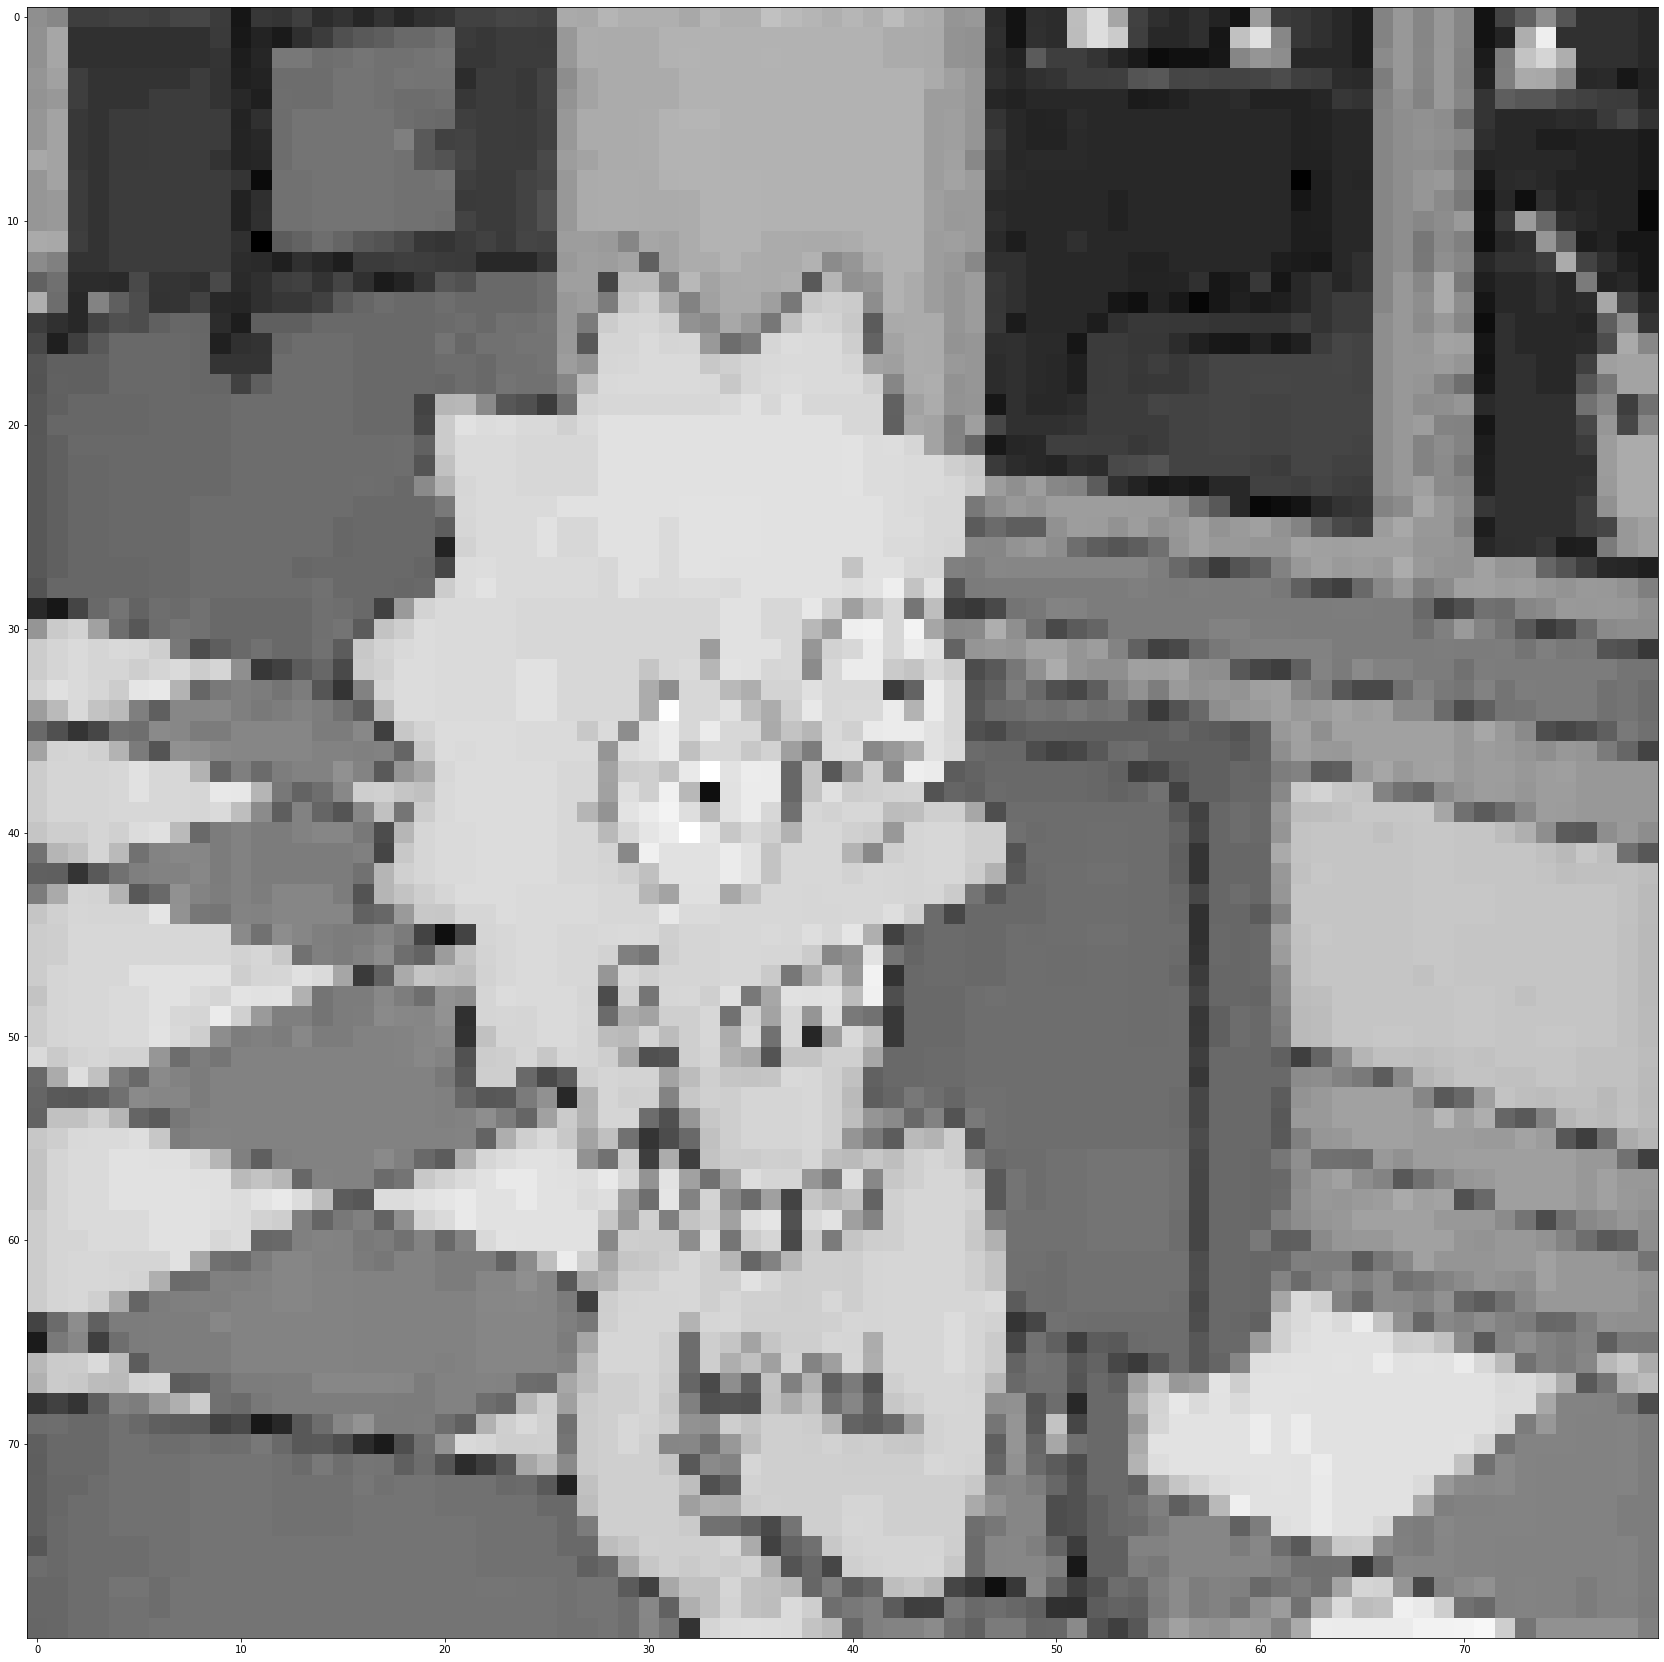

In [12]:

# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [14]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)


In [15]:

from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [16]:
split_data = skm.train_test_split(featureSet, labels, test_size=.2)
x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [17]:
del train
del featureSet
del labels 
gc.collect()

2853

In [18]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [19]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [20]:
# Create our model (returns a compiled model)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [22]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 333s 964ms/step - loss: 0.3734 - accuracy: 0.1465 - val_loss: 0.3336 - val_accuracy: 0.1672
Epoch 2/10
345/345 [==============================] - 302s 876ms/step - loss: 0.3241 - accuracy: 0.1607
Epoch 3/10
345/345 [==============================] - 289s 838ms/step - loss: 0.3230 - accuracy: 0.1650
Epoch 4/10
345/345 [==============================] - 385s 1s/step - loss: 0.3226 - accuracy: 0.1603
Epoch 5/10
345/345 [==============================] - 284s 822ms/step - loss: 0.3148 - accuracy: 0.1909
Epoch 6/10
345/345 [==============================] - 282s 818ms/step - loss: 0.3056 - accuracy: 0.2328
Epoch 7/10
345/345 [==============================] - 279s 810ms/step - loss: 0.3033 - accuracy: 0.2545
Epoch 8/10
345/345 [==============================] - 277s 803ms/step - loss: 0.2999 - accuracy: 0.2651
Epoch 9/10
345/345 [==============================] - 278s 806ms/step - loss: 0.2974 - accuracy: 0.2777
Epoch 10/10
345/345 [====

# Testing

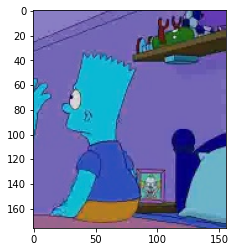

In [40]:
test_path ='/home/patricia/Documentos/opencv/deep-computer-vision/data/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_0.jpg'
img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [41]:

def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [42]:
predictions = model.predict(prepare(img))

In [43]:
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])


lisa_simpson
